In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp

# set display options
pd.set_option('display.max_columns', None)

In [291]:
zri = pd.read_csv('./data/df2.csv', index_col=0)

In [292]:
zri['MortDeliq30-89'] = zri['MortDeliq30-89'].fillna(zri['MortDeliq30-89'].mean())
zri['MortDeliq90'] = zri['MortDeliq90'].fillna(zri['MortDeliq90'].mean())
zri['education'] = zri['high_school_diploma'] + zri['associates_degree'] * 2 + zri['bachelors_degree'] * 3 +zri['masters_degree']* 4

In [294]:
zri['AGIncome'] = (zri['AGIncome']*1000)/zri['total_pop']
zri['TotIncome'] = (zri['TotIncome']*1000)/zri['total_pop']
zri['SalariesWages'] = (zri['SalariesWages']*1000)/zri['total_pop']
zri['NumUnemply'] =(zri['NumUnemply']*1000)/zri['total_pop']
zri['TotTaxes'] = (zri['TotTaxes']*1000)/zri['total_pop']

In [296]:
#remove outliers
#zri = zri[(zri.value < 3433.18)]
## zri = zri[(zri.income_per_capita < 85180.28)]
## zri = zri[(zri.TotTaxes < 2531.24)]


In [297]:
# #Log Transformation:
zri['LogValue'] = np.log(zri.value)
zri['LogTotTaxes'] = np.log(zri.TotTaxes)
# zri['LogTotIncome'] = np.log(zri.TotIncome)
# zri['LogSalariesWages'] = np.log(zri.SalariesWages)
zri['Logincome_per_capita'] = np.log(zri.income_per_capita)
# zri['Logmedian_age'] = np.log(zri.median_age)
# zri['LogAGIncome'] = np.log(zri.AGIncome)
# zri['Loggini_index'] = np.log(zri.gini_index)
# zri['Logpopulation_change'] = np.log(zri.population_change)


/Users/isa.adls/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [299]:
train = pd.merge(zri.loc[zri['Year']==2015].rename(columns = {'LogValue' : 'LogValue_2015'}),
                 zri.loc[zri['Year']==2018][['ZIPCODE', 'Month','LogValue']],
                 how = 'left', on = ['ZIPCODE', 'Month'])
test = pd.merge(zri.loc[zri['Year']==2016].rename(columns = {'LogValue' : 'LogValue_2016'}),
                zri.loc[zri['Year']==2019][['ZIPCODE', 'Month','LogValue']],
                how = 'left', on = ['ZIPCODE', 'Month'])

In [300]:
#drop columns to test

dropped = ['SizeRank', 'City', 'State', 'Metro', 'CountyName',\
        'Month', 'Year','Labor\nForce','Employed', 'Unemployed',\
        'Year-Month', 'FIPSCode', 'geo_id',\
        'value', 'year', 'TotTaxes', 'income_per_capita'] #'ZIPCODE'

train.drop(columns = dropped, inplace=True)
test.drop(columns = dropped, inplace=True)

# print(test.columns)
# train.columns

In [301]:
train.columns[test.isnull().any()]

Index(['LogValue'], dtype='object')

In [302]:
train = train.dropna(subset=['LogValue'])

In [303]:
X_train = train.drop(columns = ['LogValue'])
y_train = train['LogValue']

In [304]:
test.columns[test.isnull().any()]

Index(['LogValue'], dtype='object')

In [305]:
test = test.dropna(subset=['LogValue'])

In [308]:
X_test = test.drop(columns = ['LogValue'])
y_test = test['LogValue']

In [309]:
#show columns with missing values
print(X_train.columns[X_train.isnull().any()])
print(X_test.columns[X_test.isnull().any()])

Index([], dtype='object')
Index([], dtype='object')


In [337]:
#feature selection
model_cols = ['LogValue_2015', 'LogTotTaxes',
       'MortDeliq30-89', 'MortDeliq90',
       'white_pop', 'black_pop', 'asian_pop', 'hispanic_pop',
       'gini_index', 'Logincome_per_capita',
       'natural_amenity_rank', 'education']

model_cols2 = ['LogValue_2016','LogTotTaxes',
        'MortDeliq30-89', 'MortDeliq90',
       'white_pop', 'black_pop', 'asian_pop', 'hispanic_pop',
       'gini_index', 'Logincome_per_capita',
       'natural_amenity_rank', 'education']

X_train = X_train[model_cols]

X_test = X_test[model_cols2]


## Model Generation

In [338]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import model_selection

In [339]:
lm = LinearRegression()

lm.fit(X_train, y_train)

print("Train Score: %.4f" % lm.score(X_train, y_train))
print("Test Score:  %.4f" % lm.score(X_test, y_test))

print(lm.score(X_train, y_train)- lm.score(X_test, y_test))



Train Score: 0.9634
Test Score:  0.9543
0.009144749032678479


In [340]:
lm.intercept_, lm.coef_

(1.1430347633415447,
 array([ 0.90763529,  0.01246364, -0.01886763,  0.01565896, -0.30374057,
        -0.26335692, -0.24088229, -0.2675004 , -0.09820183, -0.02245685,
         0.02153897,  0.01578588]))

In [341]:
from sklearn.model_selection import cross_val_score
print(np.sqrt(-1* cross_val_score(lm, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs =-1)))

[0.07509215 0.07430121 0.07112064 0.07210564 0.07234085]


/Users/isa.adls/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if sys.path[0] == '':
/Users/isa.adls/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/isa.adls/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.89663010641153, tolerance: 0.23463986036698162
  positive)


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

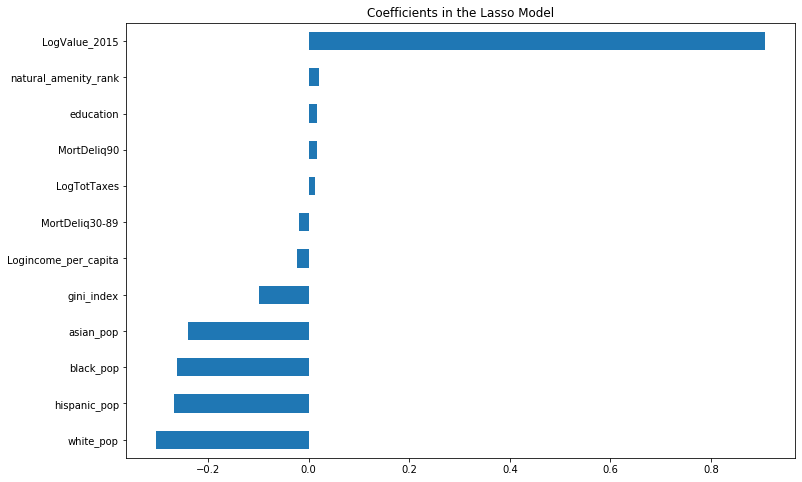

In [342]:
# param_grid={'alpha': np.logspace(-5, -3, 100)}
# grid_search = model_selection.GridSearchCV(estimator = Lasso(), param_grid = param_grid, cv=3)
# grid_search.fit(X_train, y_train)

# print("Cross Validation")
# print("-" * 20)
# print("Best parameter: ", grid_search.best_params_)
# print("Best CV score:  %.4f" % grid_search.best_score_)

#alpha_cv = grid_search.best_estimator_.get_params()['alpha']

lasso = Lasso(alpha = 0, normalize=True).fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh", figsize = (12, 8))
plt.title("Coefficients in the Lasso Model")

In [344]:
print(lasso.score(X_train, y_train))
lasso.score(X_test, y_test)

0.9634361953341429


0.9542915796646663

In [37]:
#Q-Q plot for normality
#fig4=sm.qqplot(reg1.resid, line='r')

NameError: name 'sm' is not defined

In [347]:
coefs = []
intercepts = []
R2  = []
alphaRange = np.linspace(1e-3,1,20)
for alpha in alphaRange:
    lasso.set_params(alpha=alpha, normalize = True)
    lasso.fit(X_train, y_train)
    intercepts.append(lasso.intercept_)
    coefs.append(lasso.coef_)
    R2.append(lasso.score(X_train, y_train))

Text(0.5, 1.0, 'Change of Lasso Slopes Varying Alpha')

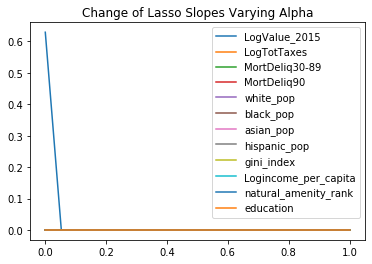

In [348]:
coefs = pd.DataFrame(np.array(coefs), columns=X_train.columns)
for name in coefs.columns:
    plt.plot(alphaRange, coefs[name], label=name)
plt.legend(loc=0)
plt.title('Change of Lasso Slopes Varying Alpha')

In [ ]:
X_train.head()

In [ ]:
y_train = pd.DataFrame(y_train)

In [ ]:
y_train.head()

In [ ]:
X_train.columns = X_train.columns.to_series().apply(lambda x: x.strip())

In [ ]:
X_train.reset_index(drop = True, inplace = True)

In [ ]:
X_train.head()

In [ ]:
y_train.reset_index(drop = True, inplace = True)

In [349]:
# import pandas as pd
# import statsmodels.api as sm

# def forward_regression(X, y,
#                        initial_list=[], 
#                        threshold_in=0.01, 
#                        threshold_out = 0.05, 
#                        verbose=True):
#     initial_list = []
#     included = list(initial_list)
#     while True:
#         changed=False
#         # forward step
#         excluded = list(set(X.columns)-set(included))
#         new_pval = pd.Series(index=excluded)
#         for new_column in excluded:
#             model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         best_pval = new_pval.min()
#         if best_pval < threshold_in:
#             best_feature = new_pval.argmin()
#             included.append(best_feature)
#             changed=True
#             if verbose:
#                 print('Add   with p-value '.format(best_feature, best_pval))

#         if not changed:
#             break

#     return included

# forward_regression(X_train, y_train)

In [350]:
def backward_regression(X, y,
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop  with p-value '.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

backward_regression(X_train, y_train)

['LogValue_2015',
 'LogTotTaxes',
 'MortDeliq30-89',
 'MortDeliq90',
 'white_pop',
 'black_pop',
 'asian_pop',
 'hispanic_pop',
 'gini_index',
 'Logincome_per_capita',
 'natural_amenity_rank',
 'education']

In [351]:
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
X = X_train
y = y_train
names=pd.DataFrame(X_train.columns)

#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 5, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
rankings

,0
0,1
1,8
2,4
3,5
4,1
5,1
6,1
7,1
8,2
9,6


In [352]:
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

         Feature  Rank
0  LogValue_2015     1
4      white_pop     1
5      black_pop     1
6      asian_pop     1
7   hispanic_pop     1


5

In [248]:
#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 8 variables: can be changed and checked in model for accuracy
rfe_mod =  RFECV(lin_reg, step=1, cv=300) #RFE(lin_reg, 4, step=1)

myvalues=rfe_mod.fit(X,y) #to fit

In [353]:
#UNIVARIATE SELECTION
# Feature Extraction with Univariate Statistical Tests (f_regression)
import pandas
import numpy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_digits

# load data
X = X_train
y = y_train
names=pd.DataFrame(X_train.columns)

model = SelectKBest(score_func=f_regression, k=4)
results = model.fit(X, y)

print (results.scores_)
#print (results.pvalues_)

results_df=pd.DataFrame(results.scores_)
#Concat and name columns
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score']).head(13)

#We can now rank the importance of each feature based on their score.  
#The higher the score, the more important the variable. 

[3.45012927e+05 5.91101022e+03 2.65466764e+03 2.62798039e+01
 4.39359118e+02 5.78443956e+02 3.60792121e+03 5.85021505e+02
 1.14796211e+02 3.03192355e+03 1.88411230e+03 2.48056247e+03]


,Feature,Score
3,MortDeliq90,26.279804
8,gini_index,114.796211
4,white_pop,439.359118
5,black_pop,578.443956
7,hispanic_pop,585.021505
10,natural_amenity_rank,1884.112298
11,education,2480.562470
2,MortDeliq30-89,2654.667642
9,Logincome_per_capita,3031.923545
6,asian_pop,3607.921205


In [354]:
#create a single data frame with both features and target by concatonating
train_df=pd.concat([X_train, y_train], axis=1)
train_df.head()

,LogValue_2015,LogTotTaxes,MortDeliq30-89,MortDeliq90,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,Logincome_per_capita,natural_amenity_rank,education,LogValue
0,7.421776,6.350867,2.300000,3.00000,0.815625,0.026682,0.071471,0.060639,0.5041,11.084002,3.0,1.828814,7.458763
2,7.036148,6.229107,2.149178,2.17876,0.581662,0.062797,0.155716,0.173303,0.3454,10.767516,3.0,1.264326,7.101676
3,7.507690,6.965521,2.300000,3.00000,0.804186,0.043573,0.057157,0.066750,0.5235,11.163567,3.0,1.693632,7.515345
4,6.858565,4.276235,4.500000,2.10000,0.111496,0.015401,0.009632,0.853346,0.4264,9.978920,5.0,0.659715,6.800170
5,7.243513,5.445087,2.300000,3.00000,0.542195,0.192627,0.104966,0.122316,0.5263,10.564266,3.0,1.471915,7.288244


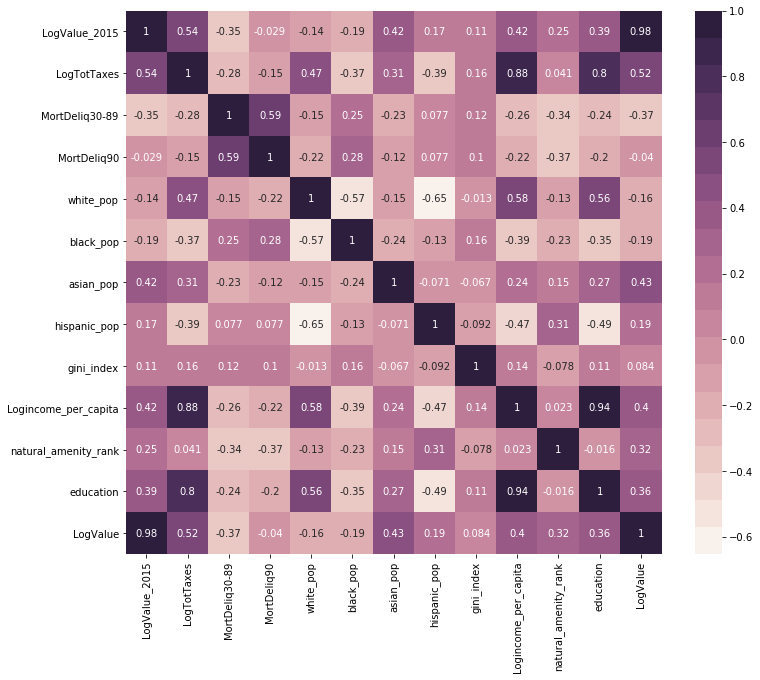

In [355]:
#Visualize corelations
import seaborn as sns
plt.figure(figsize=(12,10))
ax=sns.heatmap(train_df.corr(), annot=True, cmap=sns.cubehelix_palette(20,  light=0.95, dark=0.15))
ax.xaxis.tick_top
plt.show()

In [356]:
train_df.head()

,LogValue_2015,LogTotTaxes,MortDeliq30-89,MortDeliq90,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,Logincome_per_capita,natural_amenity_rank,education,LogValue
0,7.421776,6.350867,2.300000,3.00000,0.815625,0.026682,0.071471,0.060639,0.5041,11.084002,3.0,1.828814,7.458763
2,7.036148,6.229107,2.149178,2.17876,0.581662,0.062797,0.155716,0.173303,0.3454,10.767516,3.0,1.264326,7.101676
3,7.507690,6.965521,2.300000,3.00000,0.804186,0.043573,0.057157,0.066750,0.5235,11.163567,3.0,1.693632,7.515345
4,6.858565,4.276235,4.500000,2.10000,0.111496,0.015401,0.009632,0.853346,0.4264,9.978920,5.0,0.659715,6.800170
5,7.243513,5.445087,2.300000,3.00000,0.542195,0.192627,0.104966,0.122316,0.5263,10.564266,3.0,1.471915,7.288244


In [359]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# load data
X = X_train
y = y_train

# Use L1 penalty
estimator = LassoCV(cv=5, normalize = True)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(estimator, threshold=0.01, prefit=False, norm_order=1, max_features=None)

sfm.fit(X, y)

feature_idx = sfm.get_support()
feature_name = X.columns[feature_idx]
feature_name


Index(['LogValue_2015', 'MortDeliq30-89', 'MortDeliq90', 'white_pop',
       'asian_pop', 'gini_index', 'natural_amenity_rank'],
      dtype='object')

In [360]:
n_features = sfm.transform(X).shape[1]
n_features

7

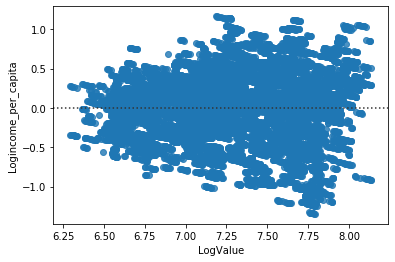

In [362]:
# simple plot of residuals
import seaborn as sns

sns.residplot('LogValue', 'Logincome_per_capita', data=train_df)

In [363]:
#sns.distplot(np.log(train_df['income_per_capita']), kde = True, color = 'r', hist_kws={'alpha': 0.9})

In [ ]:
#sns.distplot(np.log(train_df['SalariesWages']), kde = True, color = 'r', hist_kws={'alpha': 0.9})


In [ ]:
#sns.distplot(np.log(train_df['SalariesWages']), kde = True, color = 'r', hist_kws={'alpha': 0.9})


In [ ]:
#sns.distplot(np.log(train_df['TotTaxes']), kde = True, color = 'r', hist_kws={'alpha': 0.9})

In [ ]:
# y_train['value'] = np.log(y_train.value)

In [364]:
lm.fit(X_train, y_train)

print('Linear Model')
print('-'*20)
print("Train Score:   %.5f" % lm.score(X_train, y_train))
print("Test Score:    %.5f\n" % lm.score(X_test, y_test))

Linear Model
--------------------
Train Score:   0.96344
Test Score:    0.95429



In [365]:
lasso.fit(X_train, y_train)

print('Penalized Linear Model')
print('-'*20)
print("Train Score: %.5f" % lasso.score(X_train, y_train))
print("Test Score:  %.5f" % lasso.score(X_test, y_test))

Penalized Linear Model
--------------------
Train Score: 0.00000
Test Score:  -0.00437


In [366]:
from sklearn.metrics import mean_squared_error

def expo(list_):
    return list(map(exp, list_))

print('Final Model')
print('-'*20)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)#lin_mod

    
print("R^2 Score:  %.2f" % (100*lm.score(X_train, y_train)))
print("Mean Error: $%.0f\n" % mean_squared_error(y_test, y_pred))


Final Model
--------------------
R^2 Score:  96.34
Mean Error: $0



In [369]:
# Instantiate, fit, predict
from sklearn.metrics import r2_score 


lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

# Coefficient estimates
print('Coefficients: \n', lm.coef_)

# Mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

# Explained variance score
print('R_squared score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [ 0.90763529  0.01246364 -0.01886763  0.01565896 -0.30374057 -0.26335692
 -0.24088229 -0.2675004  -0.09820183 -0.02245685  0.02153897  0.01578588]
Mean squared error: 0.01
R_squared score: 0.95


In [371]:
# res_x = [target/1000 for target in expo(y_test)]
# res_y = [(target - predict)/1000 for (target, predict) in zip(expo(y_test), expo(lm.predict(y_pred)))]
# plt.figure(figsize=(8,8))
# plt.scatter(res_x, res_y, alpha = 0.5)
# plt.title('Distribution of Residuals')
# plt.xlabel('Actual House Price in $K')
# plt.ylabel('Residual House Price in $K')

In [372]:
train_set = pd.concat([X_train, y_train], axis=1)

In [373]:
train_set.head()

,LogValue_2015,LogTotTaxes,MortDeliq30-89,MortDeliq90,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,Logincome_per_capita,natural_amenity_rank,education,LogValue
0,7.421776,6.350867,2.300000,3.00000,0.815625,0.026682,0.071471,0.060639,0.5041,11.084002,3.0,1.828814,7.458763
2,7.036148,6.229107,2.149178,2.17876,0.581662,0.062797,0.155716,0.173303,0.3454,10.767516,3.0,1.264326,7.101676
3,7.507690,6.965521,2.300000,3.00000,0.804186,0.043573,0.057157,0.066750,0.5235,11.163567,3.0,1.693632,7.515345
4,6.858565,4.276235,4.500000,2.10000,0.111496,0.015401,0.009632,0.853346,0.4264,9.978920,5.0,0.659715,6.800170
5,7.243513,5.445087,2.300000,3.00000,0.542195,0.192627,0.104966,0.122316,0.5263,10.564266,3.0,1.471915,7.288244


In [375]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
print ("OLS regression model for the association between ZRI value and asian_pop")
# reg1 is the model name , followed by equal sign. 
reg1 = smf.ols(formula = 'LogValue ~ asian_pop', data=train_set).fit()
# print the result
print (reg1.summary())

OLS regression model for the association between ZRI value and asian_pop
                            OLS Regression Results                            
Dep. Variable:               LogValue   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     3608.
Date:                Sat, 19 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:48:59   Log-Likelihood:                -5705.9
No. Observations:               16232   AIC:                         1.142e+04
Df Residuals:                   16230   BIC:                         1.143e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [376]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
print ("OLS regression model for the association between ZRI value and income_per_capita")
# reg1 is the model name , followed by equal sign. 
reg1 = smf.ols(formula = 'LogValue ~ Logincome_per_capita', data=train_set).fit()
# print the result
print (reg1.summary())

OLS regression model for the association between ZRI value and income_per_capita
                            OLS Regression Results                            
Dep. Variable:               LogValue   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     3032.
Date:                Sat, 19 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:49:08   Log-Likelihood:                -5945.0
No. Observations:               16232   AIC:                         1.189e+04
Df Residuals:                   16230   BIC:                         1.191e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

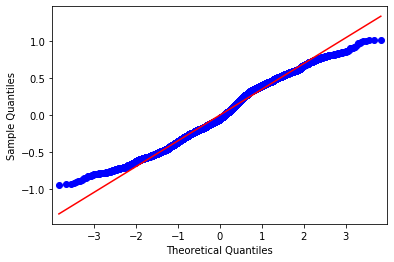

In [377]:
#Q-Q plot for normality
fig4=sm.qqplot(reg1.resid, line='r')

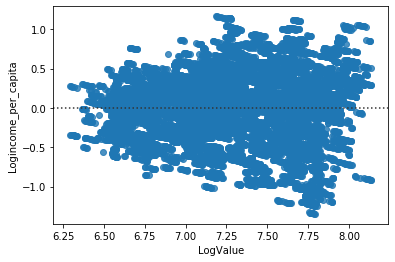

In [379]:
# simple plot of residuals
import seaborn as sns

sns.residplot('LogValue', 'Logincome_per_capita', data=train_set)

In [ ]:
train_set.columns

In [380]:
print ("\n\n---------------------")
print ("TRAIN SET INFORMATION")
print ("---------------------")
print ("Shape of training set:", train_set.shape, "\n")
print ("Column Headers:", list(train_set.columns.values), "\n")
print (train_set.dtypes)



---------------------
TRAIN SET INFORMATION
---------------------
Shape of training set: (16232, 13) 

Column Headers: ['LogValue_2015', 'LogTotTaxes', 'MortDeliq30-89', 'MortDeliq90', 'white_pop', 'black_pop', 'asian_pop', 'hispanic_pop', 'gini_index', 'Logincome_per_capita', 'natural_amenity_rank', 'education', 'LogValue'] 

LogValue_2015           float64
LogTotTaxes             float64
MortDeliq30-89          float64
MortDeliq90             float64
white_pop               float64
black_pop               float64
asian_pop               float64
hispanic_pop            float64
gini_index              float64
Logincome_per_capita    float64
natural_amenity_rank    float64
education               float64
LogValue                float64
dtype: object


In [381]:
import re
missing_values = []
nonumeric_values = []

print ("TRAINING SET INFORMATION")
print ("========================\n")

for column in train_set:
    # Find all the unique feature values
    uniq = train_set[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 10):
        print("~~Listing up to 10 unique values~~")
    print (uniq[0:10])
    print ("\n-----------------------------------------------------------------------\n")
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(train_set[column]).sum())
        missing_values.append(s)
    
    # Find features with non-numeric values
    for i in range (1, np.prod(uniq.shape)):
        if (re.match('nan', str(uniq[i]))):
            break
        if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
            nonumeric_values.append(column)
            break
  
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print ("Features with missing values:\n{}\n\n" .format(missing_values))
print ("Features with non-numeric values:\n{}" .format(nonumeric_values))
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

TRAINING SET INFORMATION

'LogValue_2015' has 2408 unique values
~~Listing up to 10 unique values~~
[7.42177579 7.03614849 7.50769008 6.85856503 7.24351297 7.53689713
 7.27378632 7.03262426 8.08425411 7.30114781]

-----------------------------------------------------------------------

'LogTotTaxes' has 1454 unique values
~~Listing up to 10 unique values~~
[6.35086727 6.22910712 6.96552063 4.27623545 5.44508714 5.06574688
 4.5592508  5.18651449 7.07649258 5.31612566]

-----------------------------------------------------------------------

'MortDeliq30-89' has 57 unique values
~~Listing up to 10 unique values~~
[2.3        2.14917826 4.5        2.7        3.2        1.7
 0.6        2.1        3.3        1.        ]

-----------------------------------------------------------------------

'MortDeliq90' has 57 unique values
~~Listing up to 10 unique values~~
[3.        2.1787599 2.1       4.3       5.8       1.1       0.7
 4.2       1.6       1.       ]

---------------------------------

In [382]:
# Check for duplicate index or rows
idsUnique = len(set(train_set.index))
idsTotal = train_set.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 16232 total entries


In [383]:
#get summary of numerical variables
train_set.describe()

,LogValue_2015,LogTotTaxes,MortDeliq30-89,MortDeliq90,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,Logincome_per_capita,natural_amenity_rank,education,LogValue
count,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000,16232.000000
mean,7.208741,5.295491,2.080028,2.091439,0.505920,0.158088,0.080139,0.222805,0.461378,10.285659,4.132701,0.973286,7.299328
std,0.387965,1.076202,0.768142,1.012056,0.260271,0.198060,0.094996,0.206948,0.052346,0.452968,1.485936,0.378077,0.380214
min,6.139885,1.474761,0.200000,0.200000,0.005237,0.000617,0.000000,0.003302,0.326100,9.173780,1.000000,0.196150,6.293419
25%,6.905753,4.596455,1.600000,1.300000,0.311214,0.030026,0.021260,0.071320,0.424900,9.976552,3.000000,0.684644,7.033506
50%,7.199678,5.332099,2.100000,2.000000,0.543967,0.079847,0.047343,0.152132,0.454900,10.255376,3.000000,0.932191,7.282761
75%,7.529943,6.051938,2.500000,2.700000,0.722533,0.197638,0.098698,0.308822,0.493400,10.608514,5.000000,1.229185,7.630947
max,8.137396,8.892779,5.900000,5.900000,0.968975,0.979294,0.732625,0.979747,0.690900,11.695214,7.000000,2.186592,8.137103


In [384]:
# Skewness of the distribution

print(train_set.skew())

# Values close to 0 show less skew


LogValue_2015           0.014384
LogTotTaxes            -0.059441
MortDeliq30-89          0.785002
MortDeliq90             0.719880
white_pop              -0.328686
black_pop               2.134712
asian_pop               2.582877
hispanic_pop            1.440239
gini_index              0.590211
Logincome_per_capita    0.189863
natural_amenity_rank    0.778618
education               0.403717
LogValue               -0.120789
dtype: float64


In [385]:
# Skewness of the distribution

print(train_set.kurt())

LogValue_2015          -0.837687
LogTotTaxes            -0.046049
MortDeliq30-89          2.180783
MortDeliq90             0.224270
white_pop              -0.985178
black_pop               4.410282
asian_pop               8.395329
hispanic_pop            1.564457
gini_index              0.450044
Logincome_per_capita   -0.291035
natural_amenity_rank   -0.752082
education              -0.392455
LogValue               -0.786163
dtype: float64


In [387]:
#Check when a value in a cloumn is zero
train_set[(train_set['LogValue'] == 0)].count()

LogValue_2015           0
LogTotTaxes             0
MortDeliq30-89          0
MortDeliq90             0
white_pop               0
black_pop               0
asian_pop               0
hispanic_pop            0
gini_index              0
Logincome_per_capita    0
natural_amenity_rank    0
education               0
LogValue                0
dtype: int64

In [388]:
df = train_set[['Logincome_per_capita','LogValue']]


In [389]:
df.head()


,Logincome_per_capita,LogValue
0,11.084002,7.458763
2,10.767516,7.101676
3,11.163567,7.515345
4,9.978920,6.800170
5,10.564266,7.288244


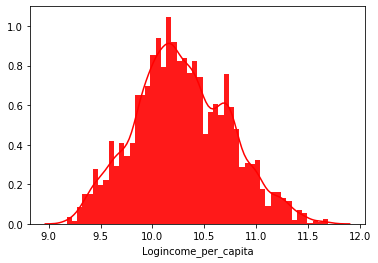

In [390]:
#draw a histogram and not fit a kernel density estimate (KDE).
sns.distplot(df['Logincome_per_capita'], kde = True, color = 'r', hist_kws={'alpha': 0.9})

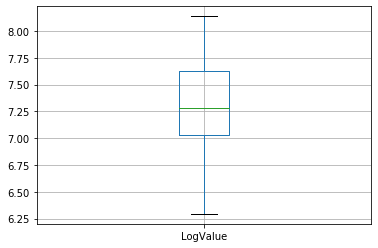

In [392]:
train_set.boxplot(column="LogValue")
#sns.boxplot(x='value', y='Year', data=train_set)

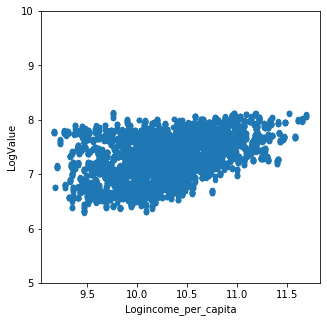

In [397]:
train_set.plot(kind="scatter",     # Create a scatterplot
              x="Logincome_per_capita",          # Put carat on the x axis
              y="LogValue",          # Put price on the y axis
              figsize=(5,5),
              ylim=(5,10))

In [398]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [399]:
gbm = GradientBoostingRegressor()

gbm.set_params(n_estimators = 1000, 
            learning_rate = .1, #.3,
            max_depth = 3, #2,
            min_samples_leaf = 3)

gbm.fit(X_train,y_train)

print('-'*50)
print("The train set R^2 is %.3f" %(gbm.score(X_train, y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test,y_test)))

--------------------------------------------------
The train set R^2 is 0.995
The test set R^2 is 0.964


In [400]:
#Random Forrest
from sklearn import ensemble

randomForest = ensemble.RandomForestRegressor()
bagging      = ensemble.BaggingRegressor()

randomForest.set_params(random_state=42, max_depth = 5, min_samples_split = 2, n_estimators=1000, max_features =4)

print(randomForest.fit(X_train,y_train))


print(randomForest.score(X_train,y_train))
randomForest.score(X_test,y_test)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
0.9373718802054932


0.9257676860260627

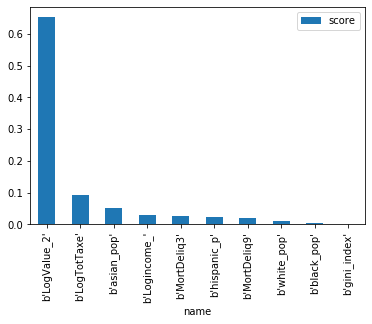

In [401]:
feature_importance = list(zip(X_train.columns[:-2], randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

In [402]:
#save to CSV
X_train.to_csv('./data/X_train.csv')
y_train.to_csv('./data/y_train.csv')
X_test.to_csv('./data/X_test.csv')
y_test.to_csv('./data/y_test.csv')

In [405]:
pip install xgboost

     |████████████████████████████████| 1.2 MB 2.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [409]:
# from xgboost import XGBRegressor
# from sklearn.metrics import accuracy_score

In [410]:
# model1 = XGBRegressor()
# model1.fit(X_train, y_train)

In [ ]:
print("The train set R^2 is %.3f" %(model1.score(X_train, y_train)))
print("The test set R^2 is %.3f" %(model1.score(X_test,y_test)))

In [ ]:
model1.get_booster().get_score(importance_type="gain")